## Overview

BERT (Bidirectional Encoder Representations from Transformers) is a method of pretraining language representations.

In this notebook I'm fine-tuning BERT model for sentiment classification using imdb dataset. Specifically, taking the pre-trained BERT model, adding one fully-connected layer, and training the new model for the classification task. I've compared the resulting model against a baseline Logistic Regression model.

## Setup

In [1]:
!pip install transformers

In [2]:
!pip install pytorch-nlp

In [3]:
import sys
import numpy as np
import random as rn
import torch
from torch import nn
from torchnlp.datasets import imdb_dataset
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

Using TensorFlow backend.


In [0]:
train_data, test_data = imdb_dataset(train=True, test=True)
rn.shuffle(train_data)
rn.shuffle(test_data)
train_data = train_data[:1000]
test_data = test_data[:100]

In [5]:
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(1000, 1000, 100, 100)

In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer.tokenize('Hi my name is Lidiya')

['hi', 'my', 'name', 'is', 'lid', '##iya']

In [7]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)

(1000, 100)

In [8]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((1000, 512), (100, 512))

In [9]:
train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((1000,), (100,), 0.494, 0.5)

In [0]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

## Baseline

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [12]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
baseline_predicted = baseline_model.predict(test_texts)

In [14]:
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

         neg       0.80      0.88      0.84        50
         pos       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100



## BERT Model

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [17]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
bert_clf = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

bert_clf.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [21]:
torch.cuda.empty_cache()
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.06816M'

## Fine-tune BERT

In [0]:
BATCH_SIZE = 4
EPOCHS = 10

In [23]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).long()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).long()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.06816M'

In [0]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [0]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [27]:
torch.cuda.empty_cache()
print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

439.06816M


In [28]:
loss_values = []
for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        bert_clf.zero_grad()  
        outputs = bert_clf(token_ids, 
                    token_type_ids=None, 
                    attention_mask=masks,
                    labels=labels)
        loss = outputs[0]
        train_loss += loss.item()
        loss.backward()
        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
    avg_train_loss = train_loss / len(train_dataloader)                
    loss_values.append(avg_train_loss)
    print("")
    print("Average training loss: {0:.2f}".format(avg_train_loss))

Epoch:  10

Average training loss: 0.02


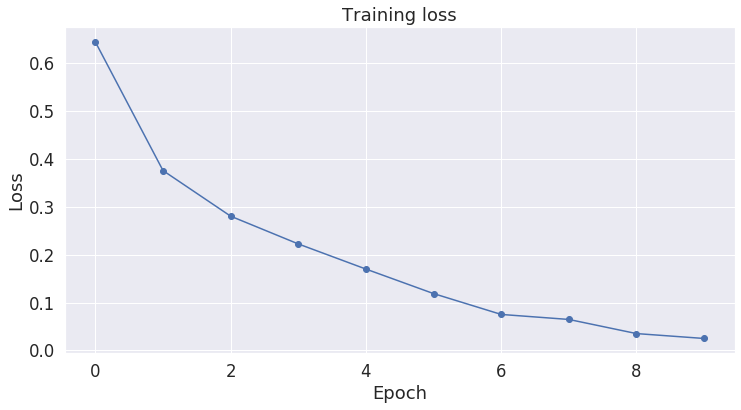

In [29]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [0]:
# Prediction on test set
bert_clf.eval()
predictions, true_labels = [], []
bert_predicted = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch_data)

        outputs = bert_clf(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

        # The predictions for this batch are a 2-column ndarray (one column for "0" 
        # and one column for "1"). Pick the label with the highest value and turn this
        # in to a list of 0s and 1s.
        pred_labels_i = np.argmax(logits, axis=1).flatten()
        bert_predicted.extend(pred_labels_i)

In [69]:
print(classification_report(test_y, bert_predicted))

              precision    recall  f1-score   support

       False       0.94      0.96      0.95        50
        True       0.96      0.94      0.95        50

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

